# Exploring Visualization Error Metrics
- The following notebook compares sample visualization error metrics as a graph for different 1D noisy data outputs
- Generates and compares L1, L2, and Linf errors as well as self-defined M1, M2, M3 errors
<br>
M1: Difference of true vs noisy max INDEX
<br>
M2: Difference of true vs noisy max VALUE
<br>
M3: Difference of true vs noisy 2nd max INDEX

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math

import sys,os
DPCOMP_PATH = '/nfs/avid/data1/miklau/dpcomp-parent/dpcomp_core_op'
sys.path.append(DPCOMP_PATH)
os.environ['DPCOMP_CORE']= DPCOMP_PATH

In [618]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("whitegrid")

In [619]:
from dpcomp_core.algorithm import *
from dpcomp_core import dataset
from dpcomp_core import util
from dpcomp_core import workload

In [620]:
# Include visual_metric.py to calculate different error metric scores
import visual_metric
visual_metric

<module 'visual_metric' from 'visual_metric.pyc'>

In [621]:
# number of bins
# domain = (256,)
domain = 256

epsilon = 0.1

nickname = 'HEPTH'
# nickname = 'BIDS-ALL'

# number of data points from sample_to_scale data generation
sample = 1e4

# ESPairs = [(0.1, 1e4), (0.01, 1e5), (0.001, 1e6)]

seeds = range(20)

ds_seed = 111

# Instantiate dataset
data = dataset.DatasetSampledFromFile(nickname=nickname, 
                                     sample_to_scale=sample, 
                                     reduce_to_dom_shape=domain, 
                                     seed=ds_seed)

# Instantiate workload
# w = workload.Identity(domain_shape=domain)
w = workload.Prefix1D(domain_shape_int=domain)

# print w.__class__.__name__

# Instantiate algorithms
a = identity.identity_engine()
b = HB.HB_engine()
c = mwemND.mwemND_engine()
d = dawa.dawa_engine()

algorithms = [a, b, c, d]
# print identity.identity_engine().short_name

In [622]:
# original data
dat = data.payload

df = pd.DataFrame(dat)
x = df.index.values
y = df.values.flatten()

# clrs = ['red' if (k == max(y)) else 'black' for k in y ]
# orig = sns.barplot(x=x, y=y, palette=clrs)

maxValOrig = max(y)
maxValIndexOrig = y.argmax()

print "Max: %d, Index: %d" % (maxValOrig, maxValIndexOrig)

Max: 122, Index: 223


In [623]:
datCDF= np.cumsum(dat)

In [631]:
errs = dict(dict())

# metr = ["M1", "M2", "M3"]
metr = ["L1", "L2", "Linf"]
# metr = ["L1", "L2", "Linf", "M1", "M2", "M3"]
# metr = ["chi-sq"]

for m in metr:
    errs[m] = {}
    for alg in algorithms:
        errs[m][alg.short_name] = []
# Use different seeds and average for a more accurate error sample
for seed in seeds:
    if seed % 10 == 0:
        print "SEED: ", seed
    for alg in algorithms:
#         print "Algorithm: ", alg.short_name
        
        x_hat = alg.Run(w, dat, epsilon, seed)
        df_hat = pd.DataFrame(x_hat)
        x_hat_data = df_hat.index.values
        y_hat_data = df_hat.values.flatten()

        # normalized non-negative rounding post-processing
        negSum = sum(y_hat_data)
        posSum = 0.00
        for i in y_hat_data:
            if i >= 0:
                posSum += i
        y_hat_data = [x*(negSum/posSum) if x >= 0 else 0 for x in y_hat_data]

        datCDF_noisy = np.cumsum(y_hat_data)
        
        settings = (epsilon, seed, ds_seed, alg, nickname, workload.Prefix1D, sample, domain)
        
        reload(visual_metric)
        vm = visual_metric.VisualMetric(y, y_hat_data, settings)
        for m in metr:
            errs[m][alg.short_name].append(vm.calcError(m))
            
# print errs

avgErrors = errs
for e in avgErrors:
    for alg in avgErrors[e]:
        v = errs[e][alg]
        if len(v) > 0:
            avgErrors[e][alg] = sum(avgErrors[e][alg])/len(avgErrors[e][alg])
        else:
            avgErrors[e][alg] = None
print avgErrors

SEED:  0
SEED:  10
{'Linf': {'HB': 0.027158498898929122, 'MWEM': 0.050300783751541969, 'Identity': 0.026144886003485902, 'DAWA': 0.017299225331123828}, 'L2': {'HB': 0.00059059060185855561, 'MWEM': 0.0010957104271801061, 'Identity': 0.00080155449025950585, 'DAWA': 0.00046537114329689812}, 'L1': {'HB': 0.0075664010938627348, 'MWEM': 0.01313287288748111, 'Identity': 0.010793462823248083, 'DAWA': 0.0059048714863046458}}


In [632]:
# Reformat as dataframe to graph as barplot
df = pd.DataFrame.from_dict(avgErrors)
df2 = df.stack()
df2 = df2.to_frame()
df3 = pd.DataFrame(df2.to_records())
df3.columns = ["alg", "metric", "error"]
df3

,alg,metric,error
0,DAWA,L1,0.005905
1,DAWA,L2,0.000465
2,DAWA,Linf,0.017299
3,HB,L1,0.007566
4,HB,L2,0.000591
5,HB,Linf,0.027158
6,Identity,L1,0.010793
7,Identity,L2,0.000802
8,Identity,Linf,0.026145
9,MWEM,L1,0.013133


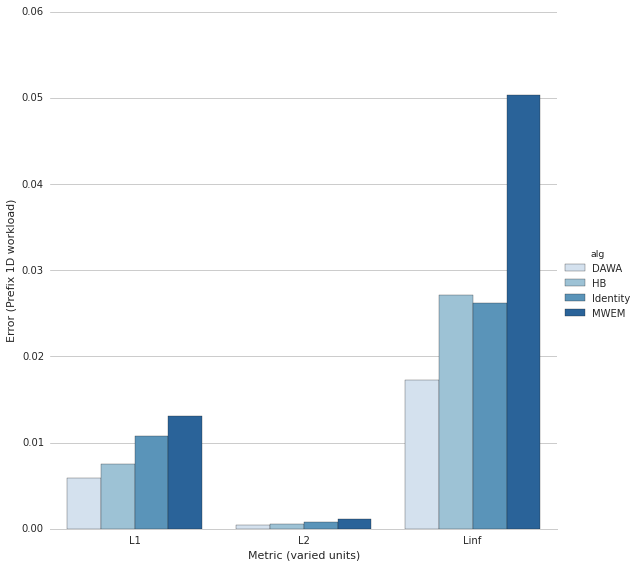

In [633]:
g = sns.factorplot(x="metric", y="error", hue="alg", data=df3, kind="bar", palette="Blues", size = 8)
g.despine(left=True)
g.set_ylabels("Error (Prefix 1D workload)")
g.set_xlabels("Metric (varied units)")

In [577]:
plotData = {}

for err in sorted(avgErrors):
    for i in sorted(avgErrors[err]):
        if avgErrors[err][i] != None:
            if err not in plotData:
                plotData[err] = [avgErrors[err][i]]
            else:
                plotData[err].append(avgErrors[err][i])
#         print err, i, avgErrors[err][i]
print plotData

{'L1': [0.0059048714863046458, 0.0075664010938627348, 0.010793462823248083, 0.01313287288748111], 'L2': [0.00046537114329689812, 0.00059059060185855561, 0.00080155449025950585, 0.0010957104271801061], 'M1': [24, 41, 9, 49], 'M3': [9, 44, 13, 47], 'M2': [14.787662600109272, 44.044600849360883, 6.2282478612989109, 50.583580982218706], 'Linf': [0.017299225331123828, 0.027158498898929122, 0.026144886003485902, 0.050300783751541969]}


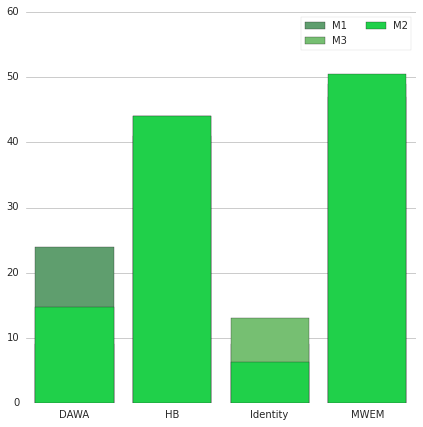

In [445]:
# Reformat to plot as barplot
f, ax = plt.subplots(figsize=(7, 7))
palettes = ["deep", "muted", "bright", "dark", "pastel"]
count = 0
for err in plotData:
    sns.set_color_codes(palettes[count])
#     print err, plotData[err]
    sns.barplot(x=["DAWA", "HB", "Identity", "MWEM"], y=plotData[err], label=err, color="g")
    count +=1
ax.legend(ncol=2, loc="upper right", frameon=True)
sns.despine(left=True, bottom=True)